In [600]:
import pandas as pd

data = pd.read_json('../data/raw/Forecasting_data_Z.json')

data.head()

,Abgabenbescheid
0,"{'Gesamtabgabe': 305.33, 'Datum Erstellung': '..."
1,"{'Gesamtabgabe': 0, 'Datum Erstellung': '2016-..."
2,"{'Gesamtabgabe': 0, 'Datum Erstellung': '2016-..."
3,"{'Gesamtabgabe': 0, 'Datum Erstellung': '2016-..."
4,"{'Gesamtabgabe': 0, 'Datum Erstellung': '2016-..."


# Datenaufbereitung und Exploration

In [601]:
extracted_data = []

for index, row in data.iterrows():
    abgabenbescheid = row['Abgabenbescheid']['Gesamtabgabe']
    datum_erstellung = row['Abgabenbescheid']['Datum Erstellung']
    
    extracted_data.append({'Abgabe': abgabenbescheid, 'Datum': datum_erstellung})

df = pd.DataFrame(extracted_data)
df.Datum = pd.to_datetime(df.Datum)
df.set_index('Datum', inplace=True)
df.head()

,Abgabe
Datum,
2014-11-13,305.33
2016-01-29,0.00
2016-03-11,0.00
2016-03-11,0.00
2016-06-06,0.00


In [602]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8928 entries, 2014-11-13 to 2024-03-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Abgabe  8927 non-null   float64
dtypes: float64(1)
memory usage: 139.5 KB


<Axes: xlabel='Datum'>

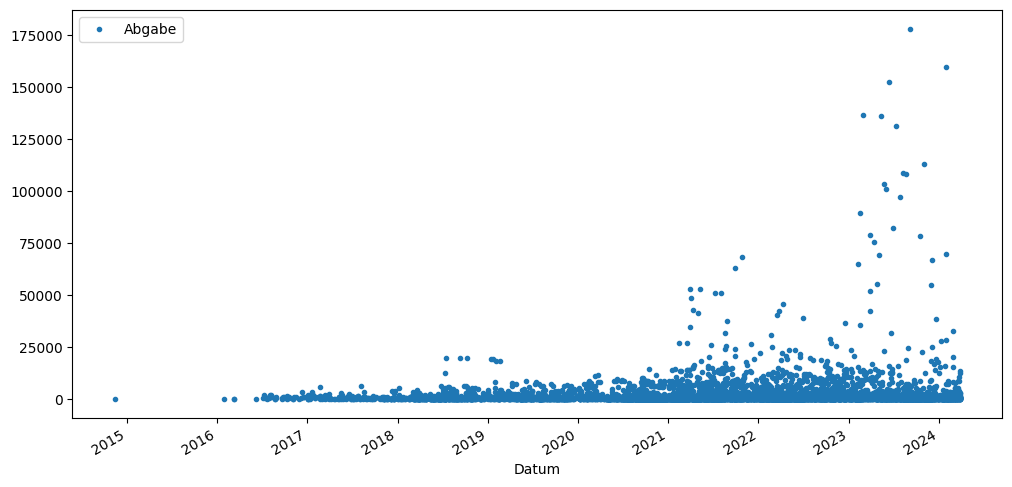

In [603]:
df.plot(style='.', figsize=(12,6))


<Axes: title={'center': 'Deklarationen pro Tag'}, xlabel='Datum'>

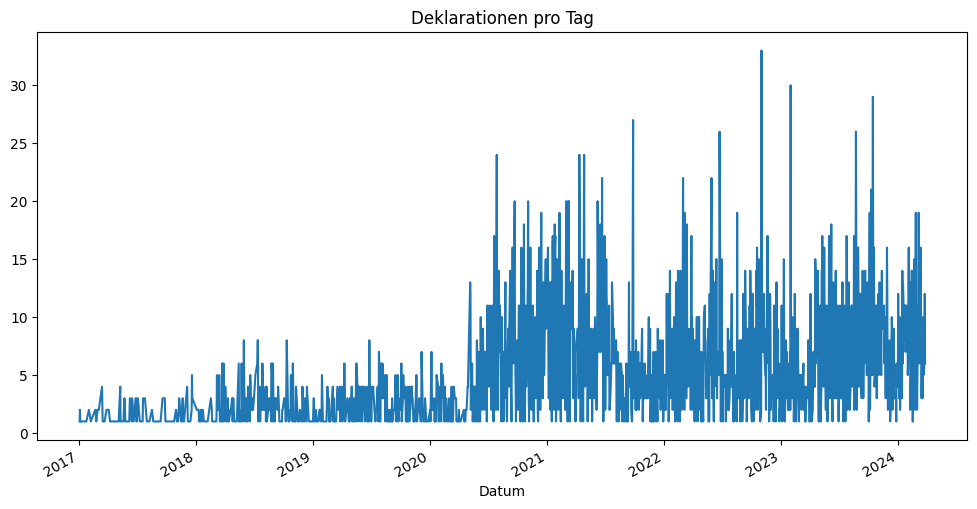

In [604]:
# Daten sind erst ab 2017 in ausreichender Güte verfügbar
df = df[df.index >= '2017-01-01']

deklarationen_pro_tag = df.groupby(df.index).size().reset_index(name='deklarationen_pro_tag')
deklarationen_pro_tag.set_index('Datum', inplace=True)
deklarationen_pro_tag.deklarationen_pro_tag.plot(figsize=(12, 6), title='Deklarationen pro Tag')


In [605]:
deklarationen_pro_tag.value_counts()

deklarationen_pro_tag
1                        325
2                        198
3                        176
4                        159
6                        110
5                        108
7                         98
9                         76
8                         74
11                        60
10                        41
12                        36
13                        35
14                        32
16                        16
15                        14
17                        13
18                         8
19                         7
20                         7
22                         3
24                         3
26                         2
21                         1
27                         1
29                         1
30                         1
33                         1
Name: count, dtype: int64

In [606]:
abgabe_pro_tag = df.groupby(df.index)['Abgabe'].sum().reset_index()
abgabe_pro_tag.set_index('Datum', inplace=True)
abgabe_pro_tag = abgabe_pro_tag.resample('D').asfreq().fillna(0)
abgabe_pro_tag

,Abgabe
Datum,
2017-01-02,439.79
2017-01-03,2107.94
2017-01-04,215.37
2017-01-05,0.00
2017-01-06,0.00
...,...
2024-03-23,0.00
2024-03-24,0.00
2024-03-25,8208.98


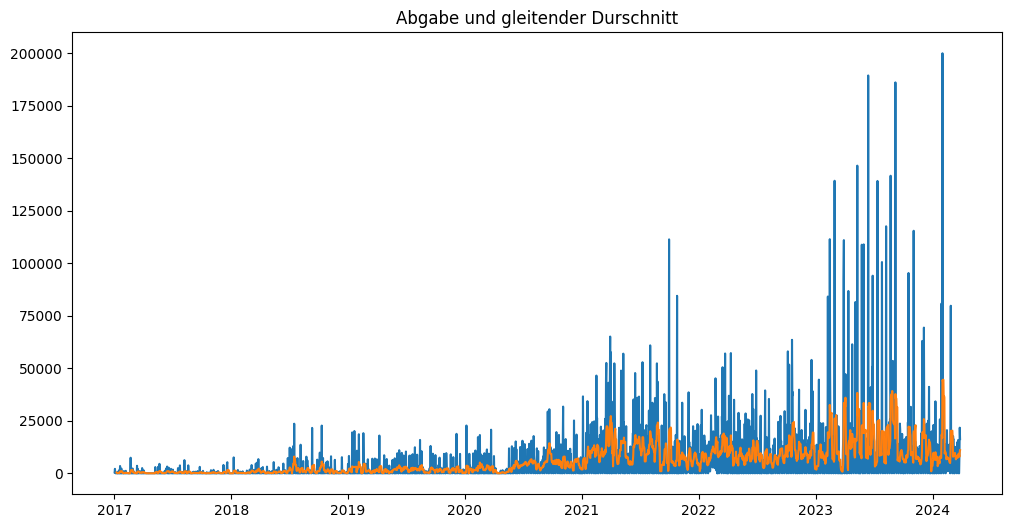

In [607]:
import matplotlib.pyplot as plt
abgabe_pro_tag['Abgabe_movavg'] = abgabe_pro_tag.Abgabe.rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(abgabe_pro_tag)
plt.title('Abgabe und gleitender Durschnitt')
plt.show()

# Weitere Aspekte der Daten Exploration

#### Saisonalität, Trend und Resudien (Adfuller-test)

In [608]:
abgabe_pro_tag.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2642 entries, 2017-01-02 to 2024-03-27
Freq: D
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Abgabe         2642 non-null   float64
 1   Abgabe_movavg  2636 non-null   float64
dtypes: float64(2)
memory usage: 61.9 KB


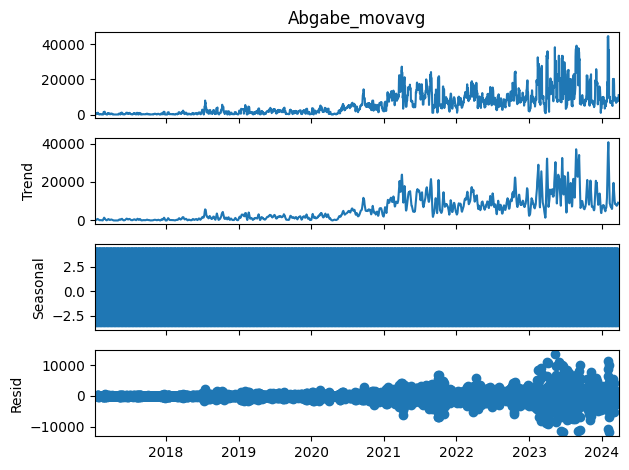

In [609]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(abgabe_pro_tag["Abgabe_movavg"].dropna()) 
decomposed.plot(); plt.show()

In [610]:
from data_preperation import check_stationarity

check_stationarity(abgabe_pro_tag.Abgabe_movavg.dropna())

'Stationary	 p-value:0.021359465027230594 	 lags:28


('Stationary', 0.021359465027230594)

#### Autokorelation und partielle Autokorrelation

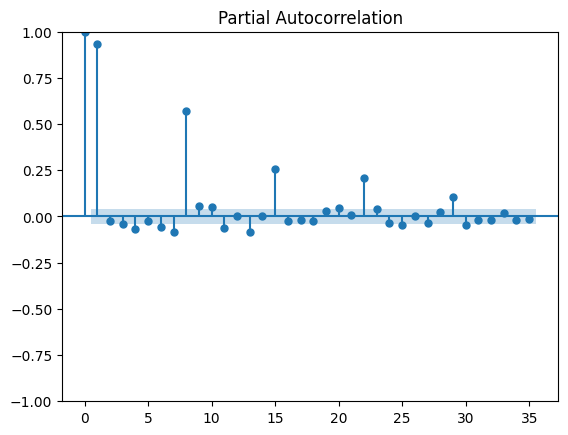

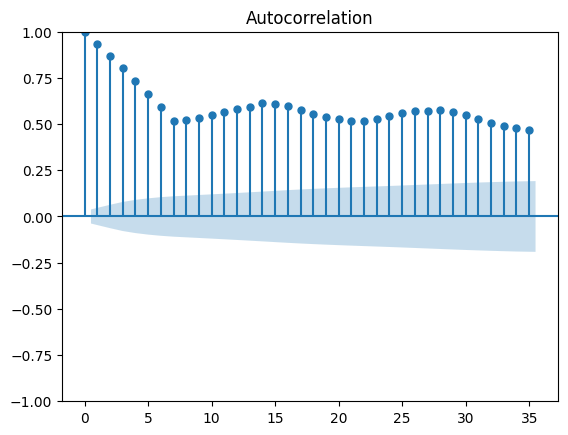

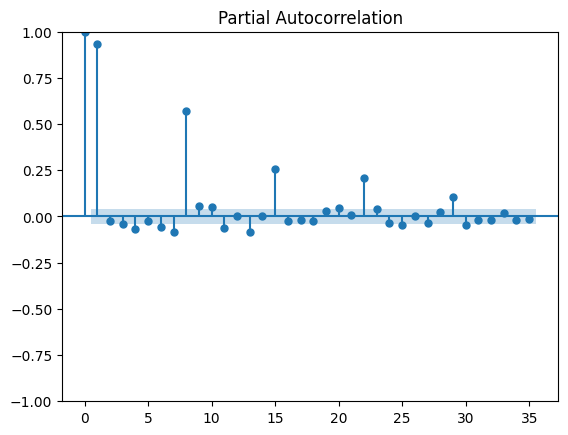

In [611]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(abgabe_pro_tag.Abgabe_movavg.dropna())
plot_pacf(abgabe_pro_tag.Abgabe_movavg.dropna())


#### Standardabweichung

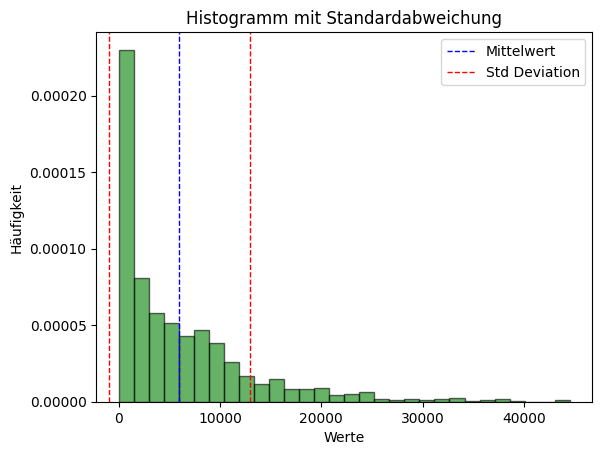

In [612]:
import numpy as np

std_dev = np.std(abgabe_pro_tag.Abgabe_movavg)

plt.hist(abgabe_pro_tag.Abgabe_movavg, bins=30, density=True, alpha=0.6, color='g', edgecolor='black')  # Histogramm der Daten
plt.axvline(np.mean(abgabe_pro_tag.Abgabe_movavg), color='b', linestyle='dashed', linewidth=1, label='Mittelwert')  # Mittelwertlinie
plt.axvline(np.mean(abgabe_pro_tag.Abgabe_movavg) + std_dev, color='r', linestyle='dashed', linewidth=1, label='Std Deviation')  # Linie für Standardabweichung
plt.axvline(np.mean(abgabe_pro_tag.Abgabe_movavg) - std_dev, color='r', linestyle='dashed', linewidth=1)  # Linie für Standardabweichung
plt.legend()
plt.title('Histogramm mit Standardabweichung')
plt.xlabel('Werte')
plt.ylabel('Häufigkeit')
plt.show()

### Erstellung eines einheitlichen Datensatz zum Training

In [613]:
abgabe_pro_tag.head(n=15)

,Abgabe,Abgabe_movavg
Datum,,
2017-01-02,439.79,NaN
2017-01-03,2107.94,NaN
2017-01-04,215.37,NaN
2017-01-05,0.00,NaN
2017-01-06,0.00,NaN
2017-01-07,0.00,NaN
2017-01-08,0.00,394.728571
2017-01-09,0.00,331.901429
2017-01-10,0.00,30.767143


#### Lags und deren Korrelation mit der Zeitreihe

In [614]:
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.impute import Imputer

t = Lag([2,4,6]) * Imputer("nearest")
lags = t.fit_transform(abgabe_pro_tag.Abgabe_movavg.dropna())
lags.head(n=15)

,lag_2__Abgabe_movavg,lag_4__Abgabe_movavg,lag_6__Abgabe_movavg
Datum,,,
2017-01-08,394.728571,394.728571,394.728571
2017-01-09,394.728571,394.728571,394.728571
2017-01-10,394.728571,394.728571,394.728571
2017-01-11,331.901429,394.728571,394.728571
2017-01-12,30.767143,394.728571,394.728571
2017-01-13,68.945714,331.901429,394.728571
2017-01-14,68.945714,30.767143,394.728571
2017-01-15,189.147143,68.945714,331.901429
2017-01-16,189.147143,68.945714,30.767143


In [615]:
merged_df = pd.merge(abgabe_pro_tag, lags, left_index=True, right_index=True, how='right')
deklarationen_pro_tag = deklarationen_pro_tag.resample('D').asfreq().fillna(0)
combined_df = pd.merge(merged_df, deklarationen_pro_tag, left_index=True, right_index=True, how='right')

combined_df.head(n=15)

,Abgabe,Abgabe_movavg,lag_2__Abgabe_movavg,lag_4__Abgabe_movavg,lag_6__Abgabe_movavg,deklarationen_pro_tag
Datum,,,,,,
2017-01-02,NaN,NaN,NaN,NaN,NaN,1.0
2017-01-03,NaN,NaN,NaN,NaN,NaN,2.0
2017-01-04,NaN,NaN,NaN,NaN,NaN,1.0
2017-01-05,NaN,NaN,NaN,NaN,NaN,0.0
2017-01-06,NaN,NaN,NaN,NaN,NaN,0.0
2017-01-07,NaN,NaN,NaN,NaN,NaN,0.0
2017-01-08,0.00,394.728571,394.728571,394.728571,394.728571,0.0
2017-01-09,0.00,331.901429,394.728571,394.728571,394.728571,0.0
2017-01-10,0.00,30.767143,394.728571,394.728571,394.728571,1.0


In [616]:
combined_df = combined_df.dropna(subset=["Abgabe_movavg"])
combined_df

,Abgabe,Abgabe_movavg,lag_2__Abgabe_movavg,lag_4__Abgabe_movavg,lag_6__Abgabe_movavg,deklarationen_pro_tag
Datum,,,,,,
2017-01-08,0.00,394.728571,394.728571,394.728571,394.728571,0.0
2017-01-09,0.00,331.901429,394.728571,394.728571,394.728571,0.0
2017-01-10,0.00,30.767143,394.728571,394.728571,394.728571,1.0
2017-01-11,482.62,68.945714,331.901429,394.728571,394.728571,1.0
2017-01-12,0.00,68.945714,30.767143,394.728571,394.728571,0.0
...,...,...,...,...,...,...
2024-03-23,0.00,8802.720000,8593.864286,7302.094286,7798.795714,0.0
2024-03-24,0.00,8802.720000,9286.882857,7637.457143,8110.001429,0.0
2024-03-25,8208.98,7867.224286,8802.720000,8593.864286,7302.094286,6.0


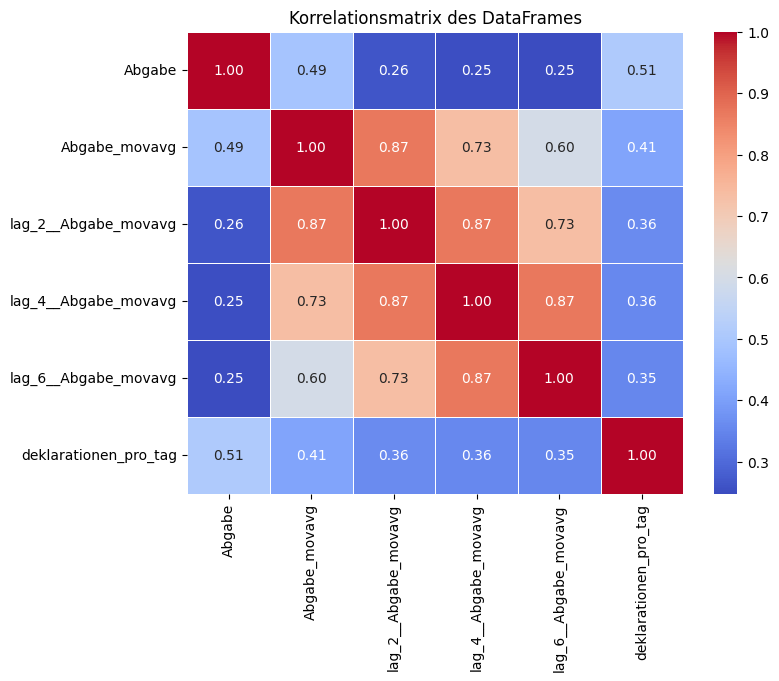

In [617]:
import seaborn as sns

corr_matrix = combined_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix des DataFrames')
plt.show()

In [618]:
nan_count = combined_df.isna().sum()
nan_count

Abgabe                   0
Abgabe_movavg            0
lag_2__Abgabe_movavg     0
lag_4__Abgabe_movavg     0
lag_6__Abgabe_movavg     0
deklarationen_pro_tag    0
dtype: int64